In [22]:
import pandas as pd 
from plotnine import (ggplot, aes, geom_line,facet_grid, theme_bw, labs)
from plotnine.options import set_option

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import r2_score 
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from mlforecast import MLForecast 
from mlforecast.utils import PredictionIntervals 

from utilsforecast.plotting import plot_series 
from utilsforecast.feature_engineering import fourier, pipeline 
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import *

import warnings 
warnings.filterwarnings("ignore")

,unique_id,metric,LinearRegression,RandomForestRegressor,BayesianRidge
0,0,mae,0.078254,0.109885,0.068028
1,0,rmse,0.105199,0.129984,0.093183
2,0,bias,0.058678,0.003180,0.059674


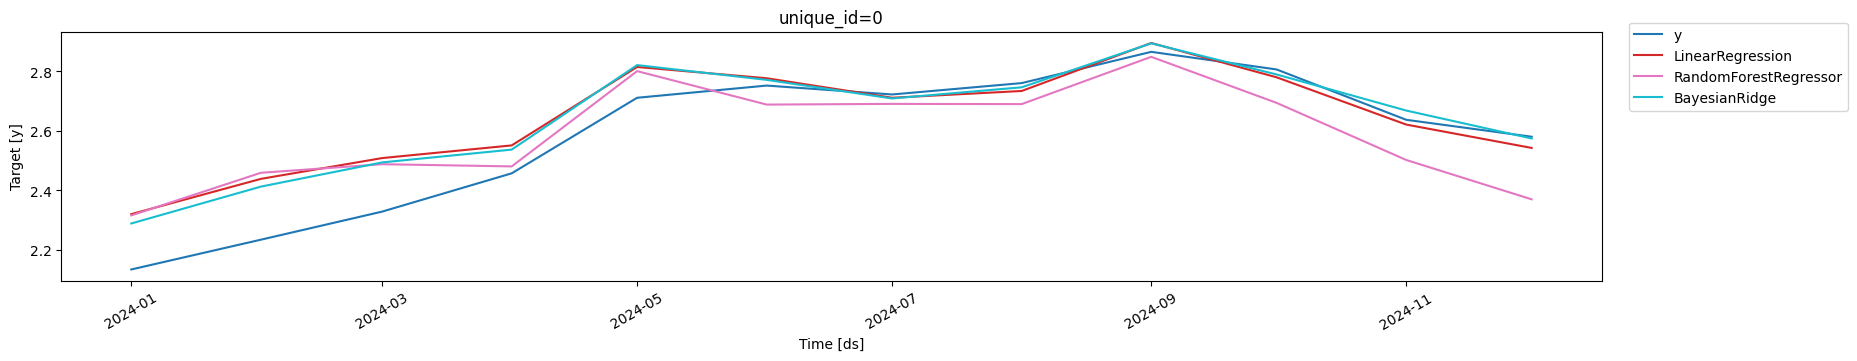

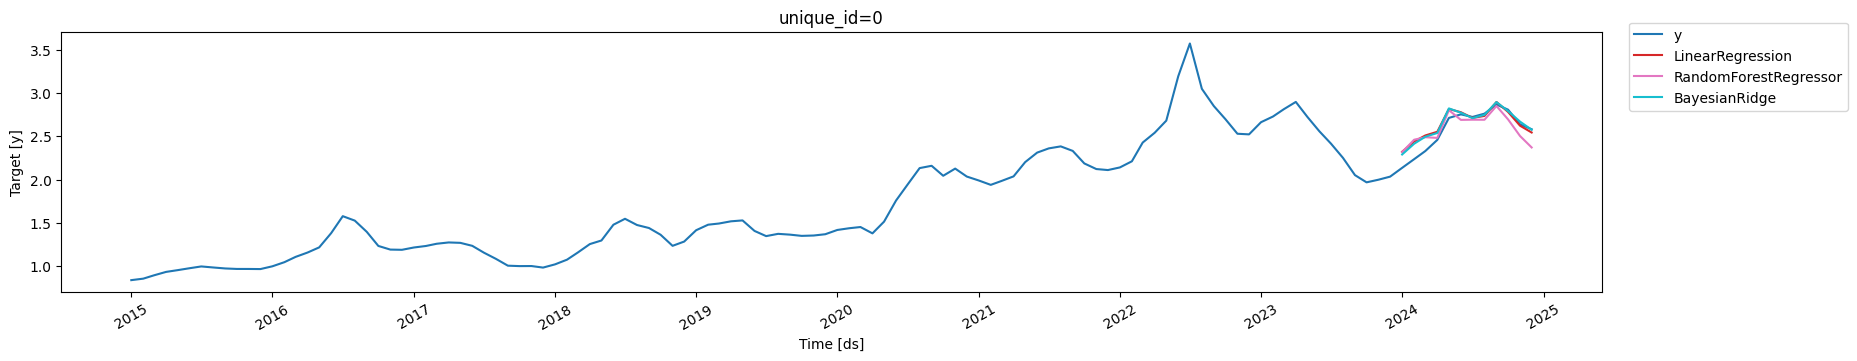

In [23]:
#Reading the data
df = pd.read_csv("../data/tidy_data.csv", parse_dates=[0]) 

#Setting target 
TARGET = 'farmgate_milk_price' 

#split the data such as the last 12 months are for validation
def train_valid_split(df:pd.DataFrame):
    train_df = df.iloc[:-12, :]
    valid_df = df.iloc[df.shape[0]-12:, :] 

    return train_df, valid_df 

#Preprocessing 
class Preprocess:

    def __init__(self, df: pd.DataFrame, date_col:str, target_col:str):
        self.df = df  
        self._raw = self.df.copy() 
        self.date_col = date_col 
        self.target_col = target_col 

    def __rename_columns(self):
        df_preprocessed = self.df.rename(columns={self.date_col: 'ds', self.target_col: 'y'}) 
        return df_preprocessed 

    def _create_id(self): 
        self.df.insert(0, 'unique_id', 0)

    def drop_nulls(self):
        self.df.dropna(axis=0, inplace=True) 
    
    def _preprocess(self):        
        self._create_id()
        self.drop_nulls()
        df_preprocessed = self.__rename_columns() 
        return df_preprocessed 

# Preprocess to Nixtla API format
engine = Preprocess(df, date_col='date', target_col=TARGET) 
df_preprocessed = engine._preprocess() 

#Split
train_df, valid_df = train_valid_split(df_preprocessed) 

#remove first 5 rows from Df 
train_df = train_df.iloc[5:, :] 

MODELS = [LinearRegression(), RandomForestRegressor(), BayesianRidge()]

#Model Fitting 
mf = MLForecast(models=MODELS,
                freq='MS',
                num_threads=-1)  

model = mf.fit(train_df, static_features=[], fitted=True)

# Prediction one-year validation
X_valid = valid_df.drop(columns=['y']) 
y_valid = valid_df['y'] 
y_preds = model.predict(12, X_df=X_valid) 

#add y to predictions for evaluation
y_preds['y'] = y_valid.values

display(evaluate(y_preds, models=[obj.__class__.__name__ for obj in MODELS], metrics=[mae, rmse, bias])) 

# plt.style.use('matplotlib')
display(plot_series(forecasts_df=y_preds, plot_random=False, engine='matplotlib')) 
display(plot_series(train_df, forecasts_df=y_preds, plot_random=False, engine='matplotlib'))  